In [1]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt

M0 = 1480 #mT
shape = [3*25.4/16, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])


In [2]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, *args
    ).x  
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res

In [3]:
folder = r"C:\Users\Brandon Nguyen\Documents\Github\magnetic-sensor-data\MLX05072024_angle_test"
file_list = sorted(glob.glob(f'{folder}/*.npz'))
len(file_list)
data = np.load(file_list[0])
pos = data['pos'][0]

In [4]:
loc_pred = [np.array([0,0,0])]
angle_pred = [np.array([0,0,0])]
B_stdev = [np.array(pos)]
for x in range(len(file_list)):
    data = np.load(file_list[x])
    mags = data['mags']
    pos = data['pos'][0]
    B = np.mean(mags, axis=0)
    mags_stdev = np.std(mags, axis=0)
    x_res = minimize(x0, B, pos, M0, shape)
    loc_pred = np.append(loc_pred, [x_res[0:3]], axis=0)
    angle_pred = np.append(angle_pred, [x_res[3:6]], axis=0)
    B_stdev = np.append(B_stdev, [mags_stdev], axis=0)
loc_pred = np.delete(loc_pred, 0, axis=0)
angle_pred = np.delete(angle_pred, 0, axis=0)
B_stdev = np.delete(B_stdev, 0 ,axis=0)

In [5]:
np.append(loc_pred, angle_pred, axis=1)
#np.sum(angle_pred**2)

array([[ 6.70047720e-01, -1.05788252e+00,  1.04458216e+01,
        -1.39687995e-01,  1.51495886e-01,  9.78537818e-01],
       [ 6.61630297e-01, -1.08175857e+00,  1.04556453e+01,
        -1.41728036e-01,  1.08057615e-01,  9.83990201e-01],
       [ 6.54824165e-01, -1.11746906e+00,  1.04657563e+01,
        -1.43064070e-01,  5.92765598e-02,  9.87936719e-01],
       [ 6.51576788e-01, -1.15948783e+00,  1.04725752e+01,
        -1.43170685e-01,  8.34708258e-03,  9.89662812e-01],
       [ 6.48941850e-01, -1.21076487e+00,  1.04767420e+01,
        -1.42412057e-01, -4.12935291e-02,  9.88945727e-01],
       [ 7.64470108e-01, -1.04218415e+00,  1.04711647e+01,
        -8.92027973e-02,  1.60883601e-01,  9.82934040e-01],
       [ 7.32895651e-01, -1.05895331e+00,  1.04845299e+01,
        -9.26402354e-02,  1.15501844e-01,  9.88977811e-01],
       [ 7.23476204e-01, -1.10488881e+00,  1.04960092e+01,
        -9.54537784e-02,  6.31919988e-02,  9.93426065e-01],
       [ 7.02638486e-01, -1.14697195e+00,  1.050

In [6]:
actang = [np.array([0, 0, 0])]
for y in range(5):
    for z in range(5):
        add = np.array([np.sin(np.deg2rad(2*y-4)), np.sin(np.deg2rad(-2*z+4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*z-4))])
        actang = np.append(actang, [add], axis=0)
actang = np.delete(actang, 0, axis=0)
locact = actang
np.sum(actang**2)

25.000148057327994

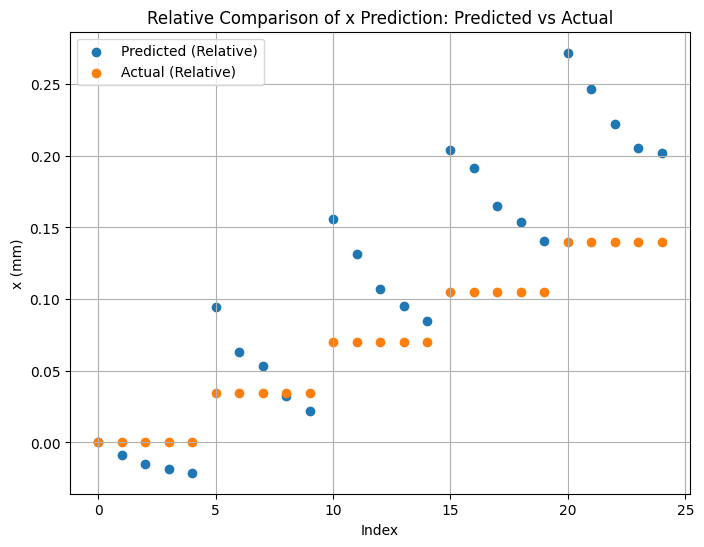

In [7]:
rel_locactx = [x-locact[0,0] for x in locact[:,0]]
rel_loc_predx = [x - loc_pred[0,0] for x in loc_pred[:,0]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predx))), rel_loc_predx, label='Predicted (Relative)')
plt.scatter(list(range(len(rel_locactx))), rel_locactx, label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('x (mm)')
plt.title('Relative Comparison of x Prediction: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

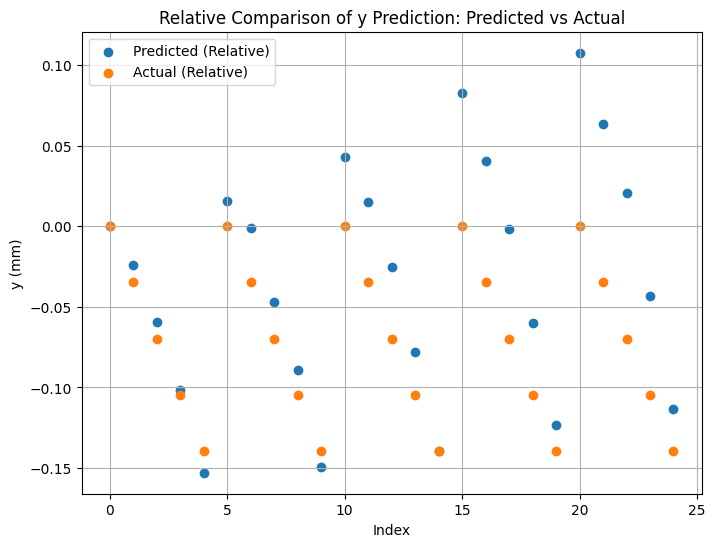

In [8]:
rel_locacty = [x-locact[0,1] for x in locact[:,1]]
rel_loc_predy = [x - loc_pred[0,1] for x in loc_pred[:,1]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predy))), rel_loc_predy, label='Predicted (Relative)')
plt.scatter(list(range(len(rel_locacty))), rel_locacty, label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('y (mm)')
plt.title('Relative Comparison of y Prediction: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()

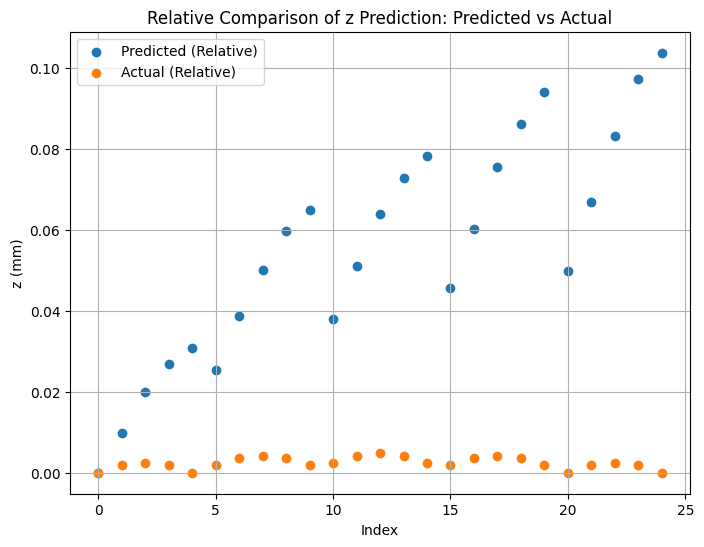

In [9]:
rel_locactz = [x-locact[0,2] for x in locact[:,2]]
rel_loc_predz = [x - loc_pred[0,2] for x in loc_pred[:,2]]

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(list(range(len(rel_loc_predz))), rel_loc_predz, label='Predicted (Relative)')
plt.scatter(list(range(len(rel_locactz))), rel_locactz, label='Actual (Relative)')
plt.xlabel('Index')
plt.ylabel('z (mm)')
plt.title('Relative Comparison of z Prediction: Predicted vs Actual')
plt.legend()
plt.grid(True)
plt.show()